In [2]:
import tensorflow as tf
import PIL
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow_history_plot import show_acc
import tensorflow_hub as hub
import pathlib

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

下下来后发现一共有5类花：daisy, dandelion, roses, sunflowers, tulips。共3670张花的图片。

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


看看每一种花有多少个训练数据。

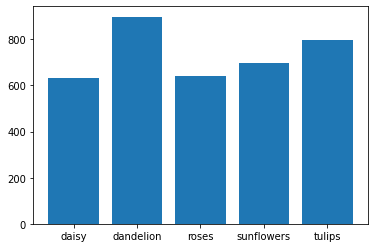

In [6]:
data = {'daisy': len(list(data_dir.glob('daisy/*.jpg'))),
        'dandelion': len(list(data_dir.glob('dandelion/*.jpg'))),
        'roses': len(list(data_dir.glob('roses/*.jpg'))),
        'sunflowers': len(list(data_dir.glob('sunflowers/*.jpg'))),
        'tulips': len(list(data_dir.glob('tulips/*.jpg')))
        }
names = list(data.keys())
values = list(data.values())
fig, ax = plt.subplots()
ax.bar(names, values)
plt.show()

随便搞几张图片看看。

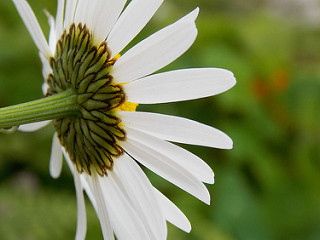

In [7]:
daisies = list(data_dir.glob('daisy/*.jpg'))
PIL.Image.open(str(daisies[0]))

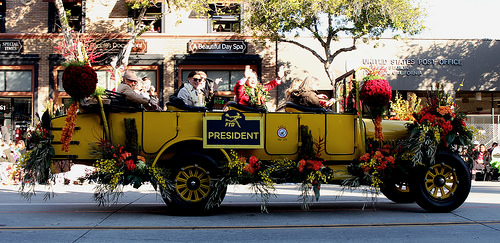

In [8]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

可以看出图片的尺寸是不一样的，所以在预处理的时候需要注意一下。并且数据集没有区分训练集和验证集，待会我们需要自己分割一下。

## 使用keras.preprocessing从文件夹加载数据集

In [9]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
print(train_ds.class_names)
print(val_ds.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


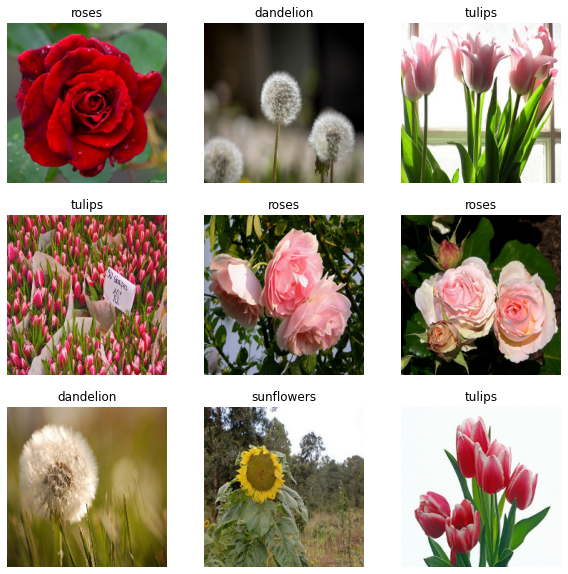

In [13]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

看看数据集的尺寸

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print('min value', np.min(image_batch[0]))
    print('max value', np.max(image_batch[0]))
    break

(32, 224, 224, 3)
(32,)
min value 0.0
max value 255.0


## Build Input Pipeline

In [15]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

In [16]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds_nor = train_ds.map(normalize_img, num_parallel_calls=AUTOTUNE) \
    .cache() \
    .shuffle(4000) \
    .prefetch(buffer_size=AUTOTUNE)
val_ds_nor = val_ds.map(normalize_img, num_parallel_calls=AUTOTUNE) \
    .cache() \
    .prefetch(AUTOTUNE)

In [17]:
for image_batch, labels_batch in train_ds_nor:
    print(image_batch.shape)
    print(labels_batch.shape)
    print('min value', np.min(image_batch[0]))
    print('max value', np.max(image_batch[0]))
    break

(32, 224, 224, 3)
(32,)
min value 0.0
max value 0.9828275


## Baseline

In [18]:
num_classes = 5

model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [19]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 10
history = model.fit(
    train_ds_nor,
    validation_data=val_ds_nor,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 47s 506ms/step - loss: 1.4350 - accuracy: 0.3877 - val_loss: 1.0546 - val_accuracy: 0.5599
Epoch 2/10
92/92 [==============================] - 42s 451ms/step - loss: 0.9431 - accuracy: 0.6311 - val_loss: 0.9901 - val_accuracy: 0.6049
Epoch 3/10
92/92 [==============================] - 42s 459ms/step - loss: 0.6772 - accuracy: 0.7524 - val_loss: 1.0587 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 42s 455ms/step - loss: 0.4249 - accuracy: 0.8434 - val_loss: 1.0879 - val_accuracy: 0.6226
Epoch 5/10
92/92 [==============================] - 42s 460ms/step - loss: 0.2308 - accuracy: 0.9328 - val_loss: 1.3739 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 43s 471ms/step - loss: 0.1054 - accuracy: 0.9729 - val_loss: 1.5603 - val_accuracy: 0.6608
Epoch 7/10
92/92 [==============================] - 44s 475ms/step - loss: 0.0437 - accuracy: 0.9903 - val_loss: 1.7281 - val_accuracy: 0.6335

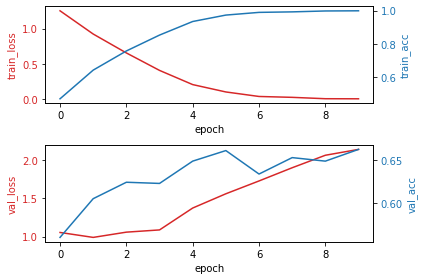

In [21]:
show_acc.plot(history)

## Baseline + Dropout + Data Argument

In [22]:
data_augmentation = Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

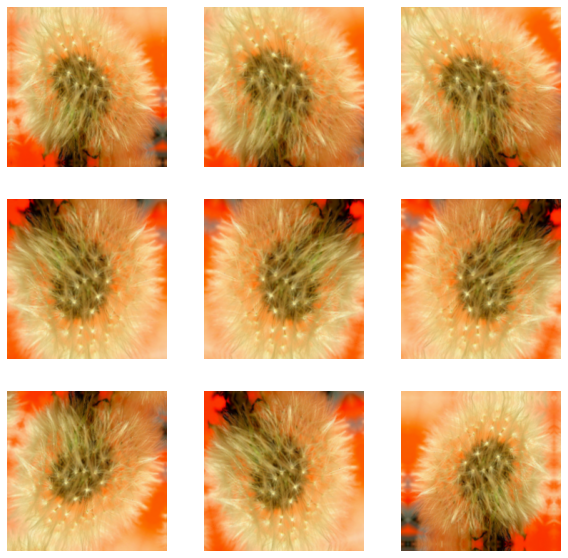

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [24]:
model3 = Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model3.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

epochs = 10
history3 = model3.fit(
    train_ds_nor,
    validation_data=val_ds_nor,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 49s 531ms/step - loss: 1.4368 - accuracy: 0.3806 - val_loss: 1.0406 - val_accuracy: 0.5913
Epoch 2/10
92/92 [==============================] - 49s 537ms/step - loss: 1.0355 - accuracy: 0.5715 - val_loss: 1.0215 - val_accuracy: 0.6035
Epoch 3/10
92/92 [==============================] - 49s 534ms/step - loss: 0.9466 - accuracy: 0.6125 - val_loss: 0.9056 - val_accuracy: 0.6512
Epoch 4/10
92/92 [==============================] - 49s 538ms/step - loss: 0.9204 - accuracy: 0.6401 - val_loss: 0.8556 - val_accuracy: 0.6812
Epoch 5/10
92/92 [==============================] - 49s 537ms/step - loss: 0.8553 - accuracy: 0.6633 - val_loss: 0.8637 - val_accuracy: 0.6866
Epoch 6/10
92/92 [==============================] - 50s 545ms/step - loss: 0.8353 - accuracy: 0.6740 - val_loss: 0.8492 - val_accuracy: 0.6921
Epoch 7/10
92/92 [==============================] - 50s 547ms/step - loss: 0.7714 - accuracy: 0.6993 - val_loss: 0.8632 - val_accuracy: 0.6757

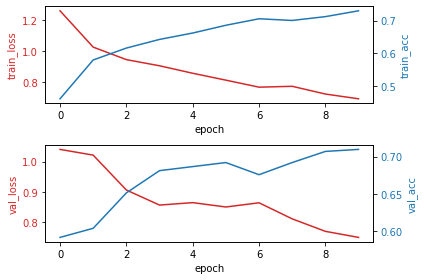

In [25]:
show_acc.plot(history3)

## Transfer Learning

In [26]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_model, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                         trainable=False)

In [27]:
model4 = Sequential([
  feature_extractor_layer,
  layers.Dense(5)
])

In [28]:
model4.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [29]:
history4 = model4.fit(train_ds_nor,
                      epochs=10,
                      validation_data=val_ds_nor)

Epoch 1/10
92/92 [==============================] - 55s 570ms/step - loss: 1.0960 - accuracy: 0.5760 - val_loss: 0.4365 - val_accuracy: 0.8651
Epoch 2/10
92/92 [==============================] - 51s 556ms/step - loss: 0.3726 - accuracy: 0.8758 - val_loss: 0.3567 - val_accuracy: 0.8815
Epoch 3/10
92/92 [==============================] - 50s 547ms/step - loss: 0.2918 - accuracy: 0.9112 - val_loss: 0.3301 - val_accuracy: 0.8815
Epoch 4/10
92/92 [==============================] - 49s 539ms/step - loss: 0.2347 - accuracy: 0.9336 - val_loss: 0.3145 - val_accuracy: 0.8856
Epoch 5/10
92/92 [==============================] - 50s 540ms/step - loss: 0.2000 - accuracy: 0.9435 - val_loss: 0.3070 - val_accuracy: 0.8856
Epoch 6/10
92/92 [==============================] - 50s 543ms/step - loss: 0.1791 - accuracy: 0.9541 - val_loss: 0.2978 - val_accuracy: 0.8992
Epoch 7/10
92/92 [==============================] - 50s 540ms/step - loss: 0.1517 - accuracy: 0.9632 - val_loss: 0.3051 - val_accuracy: 0.9033

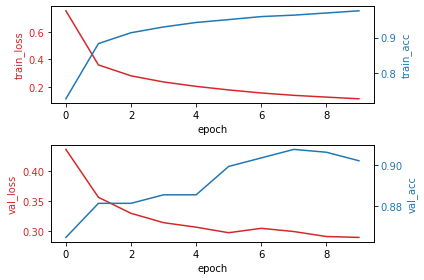

In [30]:
show_acc.plot(history4)